# Snake

Zach Goodenow <br>
10/21/18 <br>

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from random import randint
from IPython.display import clear_output
import time

In [2]:
# FOR TIMING CELLS IN MILLS
current_milli_time = lambda: int(round(time.time() * 1000))

In [3]:
class Snake(object):
    
    def __init__(self):
        self.board = np.zeros((10, 10), dtype=str)    # 10x10 board
        self.board[:] = ' '                           # set white space
        self.iApple = (randint(0,8), randint(0,9))    # set index of apple '#'  - anywhere but bottom row
        self.iHead = (9, randint(0,9))                # set index of head  'O'  - anywhere on bottom row
        self.aBody = []                               # set indexs of body '+'  - empty to start
        self.hitAppleOnLastMove = False               # keep track of last move - used in move head
        self.stateList = [self.getState()]            # keep track of all states/moves - used in move/unmakemove
    
    # NOTE: state list is managed by make move and unmake move exclusively  
    def getState(self):
        return (self.iApple, self.iHead, tuple(self.aBody), self.hitAppleOnLastMove)
    
    # NOTE: state list is managed by make move and unmake move exclusively
    def setState(self, state):
        self.iApple = state[0]
        self.iHead = state[1]
        self.aBody = list(state[2])
        self.hitAppleOnLastMove = state[3]

# GETS ------------
    # returns (row,col) of head
    def getHead(self):
        return self.iHead
    
    # returns (row,col) of apple
    def getApple(self):
        return self.iApple
    
    # returns length of body (i.e. count apples eatten)
    def getBodyLength(self):
        return len(self.aBody)

# SETS ------------ (should prob be private)
    # places pieces in their spot on the board. only used before printing
    def setupBoard(self):
        self.board[:] = ' '                # set all to empty
        self.board[self.iApple] = '#'      # place apple
        for part in self.aBody:
            self.board[part] = '+'         # place body part - needs to be before head for case when apple is eatten
        self.board[self.iHead] = 'O'       # place head
        return self
    
    # sets apple at random empty spot
    def setRandomApple(self):
        newiApple = (randint(0,9), randint(0,9))
        # make sure new apple is set to empty spot
        while( (newiApple in self.aBody) or (newiApple == self.iHead) ):
            newiApple = (randint(0,9), randint(0,9))
        self.iApple = newiApple # set apple - anywhere but bottom row
        return self
    
    # is in charge of moving entire snake forward one space.
    def moveHead(self, move):
        if self.iHead == move: # TODO: ADD CASE FOR WHEN MOVE IS SAME AS IHEAD i.e. move wasnt made
            return self
        hitApple = (move == self.iApple)               # True if move makes snake eat apple. False otherwise
        hitBody = (move in self.aBody)                 # True if move makes snake hit body. False otherwise
        # TODO: maybe add case for collision
        #if hitBody:
            #raise ValueError('HIT BODY - GAME OVER!')
        
        if not self.hitAppleOnLastMove:
            self.aBody = [self.iHead] + self.aBody         # move front of body forward one space
            self.aBody = self.aBody[:-1]                   # move back of body forward one space
        if hitApple:
            self.hitAppleOnLastMove = True
            self.aBody = [move] + self.aBody           # add body part at move
            self.setRandomApple()                      # move apple to new random location if apple was eatten
        else:
            self.hitAppleOnLastMove = False
        
        self.iHead = move
        return self

    
# MOVES ------------
    # returns valid moves (up, down, left, right) that dont cause collision
    def getMoves(self):
        # return ['w','s','a','d']
        validMoves = []
        
        curRow = self.iHead[0]
        curCol = self.iHead[1]
        
        rowUp = curRow-1 if (curRow != 0) else 9
        rowDown = curRow+1 if (curRow != 9) else 0
        colLeft = curCol-1 if (curCol != 0) else 9
        colRight = curCol+1 if (curCol != 9) else 0
        
        if (rowUp, curCol) not in self.aBody:
            validMoves += ['w']
        if (rowDown, curCol) not in self.aBody:
            validMoves += ['s']
        if (curRow, colLeft) not in self.aBody:
            validMoves += ['a']
        if (curRow, colRight) not in self.aBody:
            validMoves += ['d']

        return validMoves
    
    def makeMove(self, move):
        rowMove = self.iHead[0]
        colMove = self.iHead[1]
        
        if move == 'q': # quit
            raise ValueError('YOU QUIT THE GAME! SCORE:', len(self.aBody))
            
        elif move == 'p': # print current state of board
            self.printState()
            return self
            
        elif move == 'h': # print moves and navigation options
            self.printMoves()
            self.printNav()
            return self
        
        elif move == 'u': # unmake last move
            self.unmakeMove()
            return self
            
        elif move == 'w': # up
            rowMove = rowMove-1 if (rowMove != 0) else 9
                
        elif move == 's': # down
            rowMove = rowMove+1 if (rowMove != 9) else 0
                
        elif move == 'a': # left
            colMove = colMove-1 if (colMove != 0) else 9
                
        elif move == 'd': # right
            colMove = colMove+1 if (colMove != 9) else 0
        
        if move in ['w', 's', 'a', 'd']:
            self.moveHead((rowMove, colMove))
            self.stateList = [self.getState()] + self.stateList
            self.stateList = self.stateList[:50] # keep max of 50 states in list
        return self
    
    # Will set game back one state
    def unmakeMove(self):
        if len(self.stateList) == 1:
            raise ValueError("Snake Game Error: Cant unmake move from first state!")
        self.setState(self.stateList[1])
        self.stateList = self.stateList[1:]
        self.stateList = self.stateList[:50] # keep max of 50 states in list
        return self
    
    
# SEARCH HELPERS ---------------
    # returns manhattan dist btw head & apple. returns big number if collisioin occured
    def getDist(self):
        return abs(self.iApple[0] - self.iHead[0]) + abs(self.iApple[1] - self.iHead[1])
    
    # Returns True if hit apple or hit body
    def isOver(self):
        return len(self.getMoves()) == 0
    
    # Utility used in negamax
    def getUtility(self):
        if self.hitAppleOnLastMove:
            return 0
        elif self.iHead in self.aBody:
            return 9999
        else:
            return self.getDist()
    

# GRAPHICS -----------------
    # Print state of game - used for debugging
    def printState(self):
        print('Apple is at', self.iApple)
        print('Head is at', self.iHead)
        print('Body is at', self.aBody)
        
    def printLogo(self):
        print('████████████████████████████████████████████████████████████████████████████████████████████████████')
        print('██████████████████████   + + + + + + + + + + + + + + + + + + + + + + + + + +  ██████████████████████')
        print('██████████████████████   +  =======  ||\   ||     //\\\     || // ||=====   +  ██████████████████████')
        print('██████████████████████   +  ||       ||\\\  ||    //  \\\    ||//  ||        +  ██████████████████████')    
        print('██████████████████████   +  =======  || \\\ ||   //====\\\   ||/   ||====    +  ██████████████████████')    
        print('██████████████████████   +        || ||  \\\||  //      \\\  ||\\\  ||        +  ██████████████████████')    
        print('██████████████████████   +  =======  ||   \|| //        \\\ || \\\ ||=====   +  ██████████████████████')    
        print('██████████████████████   + + + + + + + + + + + + + + + + + + + + + + O  #     ██████████████████████')
        print('█████████████████████████████████████████████████████████████████████████████████████████████ ® 2018')


    def printGameInfo(self):
        info = []
        # objective 
        info.append('█ OBJECTIVE: make snake eat apples')
        # rules
        info.append('\n█ RULES: ')
        info.append('\t1. for every apple eatten, the snake will grow a body part')
        info.append('\t2. dont run into body, game over')
        # pices
        info.append('\n█ PICES: ')
        info.append('\tsnake = "O"')
        info.append('\tapple = "#"')
        info.append('\tbody = "+"')
        
        for line in info:
            print(line)
        self.printMoves()
        self.printNav()
        return
    
    def printMoves(self):
        info = []
        # moves
        info.append('\n█ MOVES: note - press enter (return) after each move (change later) ')
        info.append('\t"w" - move up')
        info.append('\t"s" - move down')
        info.append('\t"a" - move left')
        info.append('\t"d" - move right')
        for line in info:
            print(line)
        return
        
    def printNav(self):
        info = []
        # game navigation
        info.append('\n█ START GAME: "g"')
        info.append('█ QUIT GAME: "q"')
        info.append('█ PRINT STATE: "p"')
        info.append('█ HELP: "h"')
        info.append('█ RESTART GAME: "r"')
        for line in info:
            print(line)
        return
        
        
    # To string
    def __str__(self):
        self.setupBoard() # place all pieces on board
        top = '______________________\n' # should i add new line?
        bottom = '\n⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻' # should i add new line?
        boardData = []
        rowIndex = 0
        for row in self.board:
            boardData.append('| {} {} {} {} {} {} {} {} {} {} |'.format(*row))
            rowIndex += 1
        printBoard = top + '\n'.join(boardData) + bottom
        return printBoard

### Simple Heuristics

In [4]:
######################################################################################################################
## simple heuristic
######################################################################################################################

# 1
# first working simple move
def simpleMove1(snakeGame):
    # bestMove = 'q'
    bestMove = 'w'
    smallest = 999
    
    # save head
    saveHead = snakeGame.iHead
    
    # for move in moves
    for m in snakeGame.getMoves():
        # save move
        rowMove = snakeGame.iHead[0]
        colMove = snakeGame.iHead[1]
        
        # set head
        if m == 'w': # up
            rowMove = rowMove-1 if (rowMove != 0) else 9
        elif m == 's': # down
            rowMove = rowMove+1 if (rowMove != 9) else 0
        elif m == 'a': # left
            colMove = colMove-1 if (colMove != 0) else 9
        elif m == 'd': # right
            colMove = colMove+1 if (colMove != 9) else 0
        # set
        snakeGame.iHead = (rowMove, colMove)
        
        
        if snakeGame.getDist() < smallest:
            # if dist is smaller than smallest, set smallest/bestmove
            smallest = snakeGame.getDist()
            bestMove = m
        
        # reset head
        snakeGame.iHead = saveHead
        
    snakeGame.iHead = saveHead
        
    # return best move
    return bestMove

# 2
# Returns list of moves orded (acending) by manhattin distance (of head to apple) achieved by making that move
def getSimpleOrderedMoveList(snakeGame):
    mList = snakeGame.getMoves()
    vList = []
    for m in mList:
        snakeGame.makeMove(m)
        vList = vList + [snakeGame.getUtility()]
        snakeGame.unmakeMove()
    return [x for _,x in sorted(zip(vList,mList))]

def simpleMove2(snakeGame):
    return getSimpleOrderedMoveList(snakeGame)[0]

# 3
# return move thats next in sequence to loop board
def loopingMove(snakeGame):
    #if snakeGame.iHead in [(0,0),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8),(9,9)]
    if snakeGame.iHead[0] == snakeGame.iHead[1]:
        return 'd'
    else:
        return 'w'

### Negamax search

RETRY NEGAMAXIDS JUST ONCE

In [5]:
# Performs an iterative deepening negamax search.  Returns best move for current state and value assosicated
def negamaxIDS(game, maxDepth):
    bestValue = 999999
    bestMove = 'q'
    # bestMove = game.getMoves()[0]
    for depth in range(1, maxDepth+1):
        value, move = negamax(game, depth)
        
        if value == 0: # Found winning move, so return it
            return value, move
        elif value < bestValue: # Found a new best move
            bestValue = value
            bestMove = move

    if bestMove == 'q' or bestMove == None:
        return 666, simpleMove2(game)
    else:
        return bestValue, bestMove


# Returns the best move for the current state of the game and the value associated
def negamax(game, depthLeft):
    # If at terminal state or depth limit, return utility value and move None
    if game.isOver() or depthLeft == 0:
        return game.getUtility(), None  # call to negamax knows the move

    bestValue = 999999
    bestMove = None
    for move in getSimpleOrderedMoveList(game):
        game.makeMove(move)
        value, _ = negamax(game, depthLeft-1)
        game.unmakeMove()
        
        if value < bestValue:
            bestValue = value
            bestMove = move
    
    return bestValue, bestMove

### Negamax Alpha-Beta Pruning search

In [37]:
debug = True

# negamaxIDS but with alpha beta pruning
def negamaxIDSab(game, maxDepth, alpha = float('Inf'), beta = -float('Inf')):
    global debug
    bestValue = float('infinity')
    bestMove = None
    # bestMove = game.getMoves()[0]
    for depth in range(1, maxDepth + 1):
        value, move = negamaxab(game, depth)
        if value in {None, float('Inf')}:  # removed-> , -float('Inf')
            if debug: print('***Depth {} found {} for move {}'.format(depth, value, move))
            continue
        if value == 0: # game.getWinningValue():  # Found winning move, so return it
            if debug: print('Found winning value at depth {} with move {}'.format(depth, move))
            return value, move
        if value < bestValue:  # Found a new best move
            bestValue = value
            bestMove = move
        if debug:
            print('Depth {} has value {} for move {}'.format(depth, value, move))
            print('AND BestValue {} for BestMove {}.'.format(bestValue, bestMove))
    # return best move
    if bestMove is None:
        return 999, simpleMove1(game)
    else:
        return bestValue, bestMove


# Negamax search but with alpha beta pruning - alpha is best score so far, beta isnt used in one player game
def negamaxab(game, depthLeft, alpha = float('Inf'), beta = -float('Inf')):
    global debug
    # If at terminal state or depth limit, return utility value and move None
    if depthLeft == 0 or game.getUtility() in [0, 9999]:
        # call to negamaxab knows the move that created terminal state so return none for move to that node
        return game.getUtility(), None
    # Find best move and its value from current state
    bestValue, bestMove = None, None
    # Swap and negate alpha beta NOTE: NOT NEEDED IN ONE PLAYER GAME
    alpha, beta = -beta, -alpha
    if debug:
        print('{}\n^Game in ngmxAB -> Depth Left: {}, alpha: {}, beta: {}'.format(game, depthLeft, alpha, beta))
    for move in game.getMoves():
        # Apply a move to current state
        game.makeMove(move)

        # Use depth-first search to find eventual utility value and back it up.
        value, _ = negamaxab(game, depthLeft - 1, alpha, beta)

        # Remove the move from current state, to prepare for trying a different move
        game.unmakeMove()
        if value is None:
            continue

        # Negate it because it will come back in context of next player
        # value = - value
        if bestValue is None or value < bestValue:
            # Value for this move is better than moves tried so far from this state.
            bestValue, bestMove = value, move

        # Update alpha to minimum of bestScore and current alpha
        alpha = min(bestValue, alpha)

        if debug: print('\tmove {} has value: {}, alpha: {}, beta: {}, bestValue: {}, bestMove: {}'.format(move, value, alpha, beta, bestValue, bestMove))

        # Do early return if bestScore is less than alpha because we found a better move elsewhere
        #if bestValue < alpha:
        # Do early return if bestScore is greater than or equal to beta
        if bestValue <= beta:
            if debug:
                print('*PRUNE FOUND AT DEPTHLEFT {}* move {}. bestValue: {}, beta: {}, bestMove: {}'.format(depthLeft, move, bestValue, beta, bestMove))
            return bestValue, bestMove
    return bestValue, bestMove

Test game with user input

In [156]:
UIgame = Snake()                # init
UIgame.printLogo()              # logo
UIgame.printGameInfo()          # how to play

move = input()

if move in ['q', 'Q']: # want to quit?
    UIgame.makeMove(move)
clear_output()

# game loop
while(not UIgame.isOver()):
    print(UIgame)
    print("Valid moves:", UIgame.getMoves())
    print("Simple Move 1 Suggests:", simpleMove1(UIgame))
    print("Simple Move 2 Suggests:", simpleMove2(UIgame))
    print("NegamaxIDS depth 0 Suggests:", negamaxIDS(snakeGame, 0))
    print("NegamaxIDS depth 1 Suggests:", negamaxIDS(snakeGame, 1))
    print("NegamaxIDS depth 5 Suggests:", negamaxIDS(snakeGame, 5))
    #print("NegamaxIDS depth 10 Suggests:", negamaxIDS(snakeGame, 10))

    move = input()
    #move = simpleMove1(snakeGame) # nearest manhatten heuristic
    #value, move = negamaxIDS(snakeGame, 3) # negamax Itterative Deepening Search
    #value, move = negamaxIDSab(snakeGame, 10) # negamax Itterative Deepening Search with alpha pruning
    if move in ['b', 'n', 'N', 'no', 'No', 'NO']:
        break
    
    UIgame.makeMove(move)
    clear_output()
print('game over')

______________________
|                     |
|           O +       |
|             + #     |
|             +       |
|                     |
|                     |
|                     |
|                     |
|                     |
|                     |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Valid moves: ['w', 's', 'a']
Simple Move 1 Suggests: s
Simple Move 2 Suggests: s
NegamaxIDS depth 0 Suggests: (666, 'a')
NegamaxIDS depth 1 Suggests: (2, 'a')
NegamaxIDS depth 5 Suggests: (1, 'a')


KeyboardInterrupt: 

### Function to play game

In [161]:
from IPython.display import clear_output
import time

def startSnake(restarted = False):
    snakeGame = Snake()                # init
    if not restarted:
        snakeGame.printLogo()          # logo
        snakeGame.printGameInfo()      # how to play
    else:
        print(snakeGame)
    
    move = input()
    
    if move in ['q', 'Q']:
        snakeGame.makeMove(move)
    
    if not restarted:
        clear_output()
    # game loop
    while(not snakeGame.isOver()):#while(True):
        if move == 'r': # restart
            startSnake(True)
        print(snakeGame)
        print("State:", snakeGame.getState())
        print("Hit apple on last?", snakeGame.hitAppleOnLastMove)
        #print('Simple move suggests:', simpleMove(snakeGame))
        #move = input()
        #move = loopingMove(snakeGame)
        #move = simpleMove1(snakeGame) # nearest manhatten heuristic
        #move = simpleMove2(snakeGame) # nearest manhatten heuristic
        value, move = negamaxIDS(snakeGame, 5) # negamax Itterative Deepening Search
        #value, move = negamaxIDSab(snakeGame, 10) # negamax Itterative Deepening Search with alpha pruning
        if move in ['b', 'n', 'N', 'no', 'No', 'NO']:
            break
        snakeGame.makeMove(move)
        # check to continue every 100 apples eatten
        if len(snakeGame.aBody) > 0 and len(snakeGame.aBody) % 100 == 0: 
            print(snakeGame)
            snakeGame.printState()
            move = input("would you like to continue ")
            
        #if move != 'p': 
        #    clear_output()
        time.sleep(0.5) # wait for N seconds to replacate frames per second (FPS) - NOT NEEDED WHEN USER INPUT
        clear_output()
    print('Game over! Score: ', snakeGame.getBodyLength())
    return

In [162]:
startSnake()

______________________
|               + +   |
|               +     |
|               +     |
| + +           + + + |
|                     |
| + +       + + + +   |
| + +       +     +   |
| O +       +     + + |
| + +       +       + |
| #         + + + +   |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
State: ((9, 0), (7, 0), ((6, 0), (5, 0), (5, 1), (6, 1), (7, 1), (8, 1), (8, 0), (8, 9), (7, 9), (7, 8), (6, 8), (5, 8), (5, 7), (5, 6), (5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (9, 6), (9, 7), (9, 8), (0, 8), (0, 7), (1, 7), (2, 7), (3, 7), (3, 8), (3, 9), (3, 0), (3, 1)), False)
Hit apple on last? False


IndexError: list index out of range

(1, 2)

## Analyze heuristics

In [6]:
# play game once until game over, return score (i.e. apples eatten i.e. body length)
def playSnake(player, trace = False):
    snakeGame = Snake()                # init
    if trace:
        print(snakeGame)
        print('Moves:', snakeGame.getMoves())
    # game loop
    while(not snakeGame.isOver()):
        
        move = player(snakeGame)
        if trace: clear_output()
        snakeGame.makeMove(move)
        if trace:
            print(snakeGame)
            print('Moves:', snakeGame.getMoves())
            time.sleep(0.5)
    clear_output()
    print(snakeGame)
    print("Score:", snakeGame.getBodyLength())
    return snakeGame.getBodyLength()

In [59]:
#playScore = playSnake(input)
playScore = playSnake(simpleMove1)
playScore

______________________
|                     |
|                     |
|                     |
|                     |
| + + + + +           |
| + + +   +           |
| + O + + +           |
| + + + + + +         |
|     #     + +       |
|                     |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 21


21

In [60]:
scoreList = []
timeList = []
for i in range(10):
    sTime = current_milli_time()
    scoreList += [playSnake(simpleMove1)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("simpleMove1 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
|   + + +             |
|   +                 |
|   +                 |
|   +                 |
|   +       + +       |
|   + + +   +         |
| # + + +   +         |
|   + + +   +         |
| + + + +   +         |
| + O + +   + + + + + |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 34
simpleMove1 - avgScore: 24.5  HighScore: 34
		avgTime: 6.8  HighTime: 9  sumTime: 68


In [61]:
scoreList = []
timeList = []
for i in range(10):
    sTime = current_milli_time()
    scoreList += [playSnake(simpleMove2)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("simpleMove2 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
|                     |
|   + + +             |
|   + + +             |
|   + O +             |
|   + + +             |
|                     |
|                     |
|       #             |
|                     |
|                     |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 11
simpleMove2 - avgScore: 22.2  HighScore: 39
		avgTime: 13.2  HighTime: 21  sumTime: 132


In [ ]:
scoreList = []
for i in range(1):
    scoreList += [playSnake(loopingMove, True)]
avgScore = sum(scoreList) / len(scoreList)
avgScore

In [7]:
# play game once until game over, return score (i.e. apples eatten i.e. body length)
def playSnake4IDS(depth, trace = False):
    snakeGame = Snake()                # init
    if trace:
        print(snakeGame)
        print('Moves:', snakeGame.getMoves())
    # game loop
    while(not snakeGame.isOver()):
        value, move = negamaxIDS(snakeGame, depth) # negamax Itterative Deepening Search
        #value, move = negamaxIDSab(snakeGame, 10) # negamax Itterative Deepening Search with alpha pruning
        if trace: clear_output()
        snakeGame.makeMove(move)
        if trace:
            print(snakeGame)
            time.sleep(0.5)
    clear_output()
    print(snakeGame)
    print("Score:", snakeGame.getBodyLength())
    return snakeGame.getBodyLength()

In [51]:
scoreList = []
timeList = []
for i in range(10):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(3)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("IDS Depth 3 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
| #               +   |
|                 +   |
|                 +   |
| + + + + + + + + + + |
| O + +     + + + + + |
| +         + + + +   |
| +               + + |
|                     |
|                     |
|             + + +   |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 31
IDS Depth 3 - avgScore: 24.4  HighScore: 37
		avgTime: 134.7  HighTime: 220  sumTime: 1347


In [52]:
scoreList = []
timeList = []
for i in range(10):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(5)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("IDS Depth 5 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
| + + +               |
| + O + #       + +   |
| + + + + + + + + +   |
| + + + +       + +   |
| + + + +       +   + |
|   + + +       + + + |
|       + + + +       |
|         + + +       |
|                     |
|                     |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 41
IDS Depth 5 - avgScore: 35.1  HighScore: 41
		avgTime: 718.3  HighTime: 1006  sumTime: 7183


In [53]:
scoreList = []
timeList = []
for i in range(10):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(7)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("IDS Depth 7 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
| + + # + + + + +   + |
| O + + + + +       + |
| + + +             + |
|     + + + + + +     |
|               +     |
| + + + + + + + +     |
| +                   |
| +         + + +     |
| + + + +   + + +     |
| + +   + + + + +   + |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 53
IDS Depth 7 - avgScore: 36.4  HighScore: 53
		avgTime: 2133.5  HighTime: 3075  sumTime: 21335


In [54]:
scoreList = []
timeList = []
for i in range(10):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(15)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("IDS Depth 15 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
|         + O +       |
|         + + +       |
|     #   + +         |
|         +           |
|         +           |
|         +           |
|         +           |
|         +           |
|         + + +       |
|         + + +       |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 18
IDS Depth 15 - avgScore: 42.1  HighScore: 61
		avgTime: 71691.8  HighTime: 288263  sumTime: 716918


In [55]:
scoreList = []
timeList = []
for i in range(10):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(20)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("IDS Depth 15 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
|   + + + +         + |
|                   + |
|                   + |
|                   + |
| +     + +         + |
| +     + +     + + + |
|       + +           |
| + + + + +           |
| + O + + +         + |
|   + + + +       # + |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 36
IDS Depth 15 - avgScore: 41.3  HighScore: 51
		avgTime: 117464.0  HighTime: 973383  sumTime: 1174640


In [199]:
playSnake4IDS(20, True)

______________________
|                 +   |
|                 +   |
|                 +   |
|                 +   |
|       #   +     +   |
|           + + + +   |
|                     |
| +       + +     + + |
| + + + + + +     + O |
| + + + + + +     + + |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 31


31

# SANDBOX

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
# SORT A LIST BY OTHER LIST
mList = ['w','s','a','d']
vList = [121,231,148,221]
#newList = sorted(mList, key=lambda vList: vList)
newList = [x for _,x in sorted(zip(vList,mList))]
print(mList)
print(vList)
print(newList)

['w', 's', 'a', 'd']
[121, 231, 148, 221]
['w', 'a', 'd', 's']


In [8]:
scoreList = []
timeList = []
for i in range(50):
    sTime = current_milli_time()
    scoreList += [playSnake(simpleMove1)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("simpleMove1 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
|                     |
|       #             |
|                     |
|                     |
|                     |
|                     |
|   + + + + + + + +   |
|   + O +             |
|   + + +             |
|                     |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 13
simpleMove1 - avgScore: 24.96  HighScore: 46
		avgTime: 10.7  HighTime: 37  sumTime: 535


In [20]:
scoreList = []
timeList = []
for i in range(50):
    sTime = current_milli_time()
    scoreList += [playSnake(simpleMove2)]
    timeList = timeList + [current_milli_time() - sTime]
avgScore = sum(scoreList) / len(scoreList)
avgTime = sum(timeList) / len(timeList)
print("simpleMove2 - avgScore:",avgScore," HighScore:", max(scoreList))
print("\t\tavgTime:",avgTime," HighTime:", max(timeList)," sumTime:",sum(timeList))

______________________
|                     |
|             #     + |
|                   + |
|                 + + |
|             + + +   |
| + + +       + O + + |
| + + +       + + + + |
| + + + + + + + + + + |
| + +                 |
|                     |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 32
simpleMove2 - avgScore: 26.0  HighScore: 46
		avgTime: 18.4  HighTime: 42  sumTime: 920


In [33]:
scoreListList = []     # list of list of scores
timeListlist = []      # list of list of times
scoreList = []         # keep track of one player's socre
timeList = []          # keep track of one player's time
for i in range(50):
    sTime = current_milli_time()
    scoreList += [playSnake(simpleMove1)]
    timeList = timeList + [current_milli_time() - sTime]
scoreListList = scoreListList + [scoreList]
timeListlist = timeListlist + [timeList]

scoreList = []
timeList = []
for i in range(50):
    sTime = current_milli_time()
    scoreList += [playSnake(simpleMove2)]
    timeList = timeList + [current_milli_time() - sTime]
scoreListList = scoreListList + [scoreList]
timeListlist = timeListlist + [timeList]

scoreList = []
timeList = []
for i in range(50):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(3)]
    timeList = timeList + [current_milli_time() - sTime]
scoreListList = scoreListList + [scoreList]
timeListlist = timeListlist + [timeList]

scoreList = []
timeList = []
for i in range(50):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(5)]
    timeList = timeList + [current_milli_time() - sTime]
scoreListList = scoreListList + [scoreList]
timeListlist = timeListlist + [timeList]

scoreList = []
timeList = []
for i in range(50):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(7)]
    timeList = timeList + [current_milli_time() - sTime]
scoreListList = scoreListList + [scoreList]
timeListlist = timeListlist + [timeList]

scoreList = []
timeList = []
for i in range(50):
    sTime = current_milli_time()
    scoreList += [playSnake4IDS(15)]
    timeList = timeList + [current_milli_time() - sTime]
scoreListList = scoreListList + [scoreList]
timeListlist = timeListlist + [timeList]


______________________
|                     |
|                     |
|           + + +     |
|           + O +     |
|           + + +     |
|           + + +   + |
|           + + +   + |
|           + + + + + |
|                 #   |
|                     |
⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻⎻
Score: 21


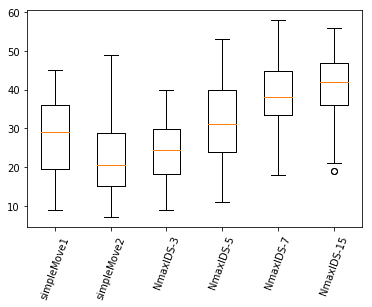

In [34]:
plt.boxplot(scoreListList)
plt.xticks([1,2,3,4,5,6], 
           ['simpleMove1', 'simpleMove2', 'NmaxIDS-3', 'NmaxIDS-5', 'NmaxIDS-7', 'NmaxIDS-15'],rotation=70);

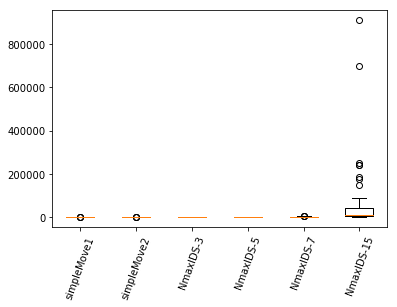

In [36]:
plt.boxplot(timeListlist)
plt.xticks([1,2,3,4,5,6], 
           ['simpleMove1', 'simpleMove2', 'NmaxIDS-3', 'NmaxIDS-5', 'NmaxIDS-7', 'NmaxIDS-15'],rotation=70);

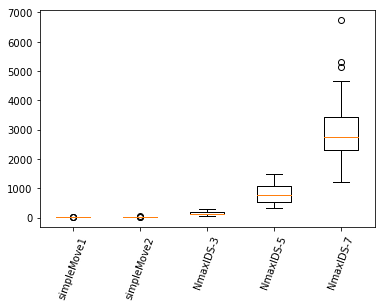

In [37]:
plt.boxplot(timeListlist[:-1])
plt.xticks([1,2,3,4,5], 
           ['simpleMove1', 'simpleMove2', 'NmaxIDS-3', 'NmaxIDS-5', 'NmaxIDS-7'],rotation=70);

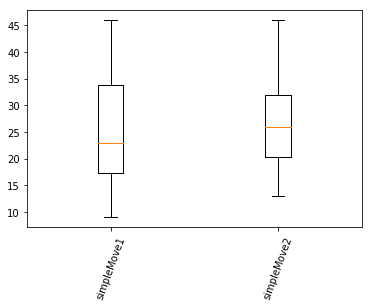

In [32]:
plt.boxplot(scoreListList)
plt.xticks([1,2], ['simpleMove1', 'simpleMove2'],rotation=70);

([<matplotlib.axis.XTick at 0x11156b320>,
 <a list of 2 Text xticklabel objects>)

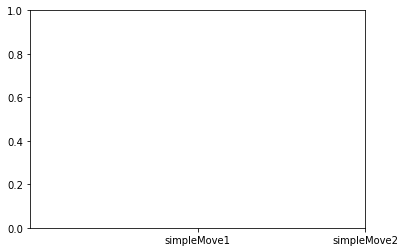

In [25]:
#plt.xticks([1, 2, 3], ['mon', 'tue', 'wed'])
plt.xticks([1, 2], ['simpleMove1', 'simpleMove2'])